In [42]:
%reset

PySPM version: 0.2.23
Channels
	S [ZSensor] "Height Sensor"
	S [] "Peak Force Error"
	S [Stiffness] "DMTModulus"
	S [LogStiffness] "LogDMTModulus"
	S [Adhesion] "Adhesion"
	S [Deformation] "Deformation"
	S [Dissipation] "Dissipation"
	S [Height] "Height"


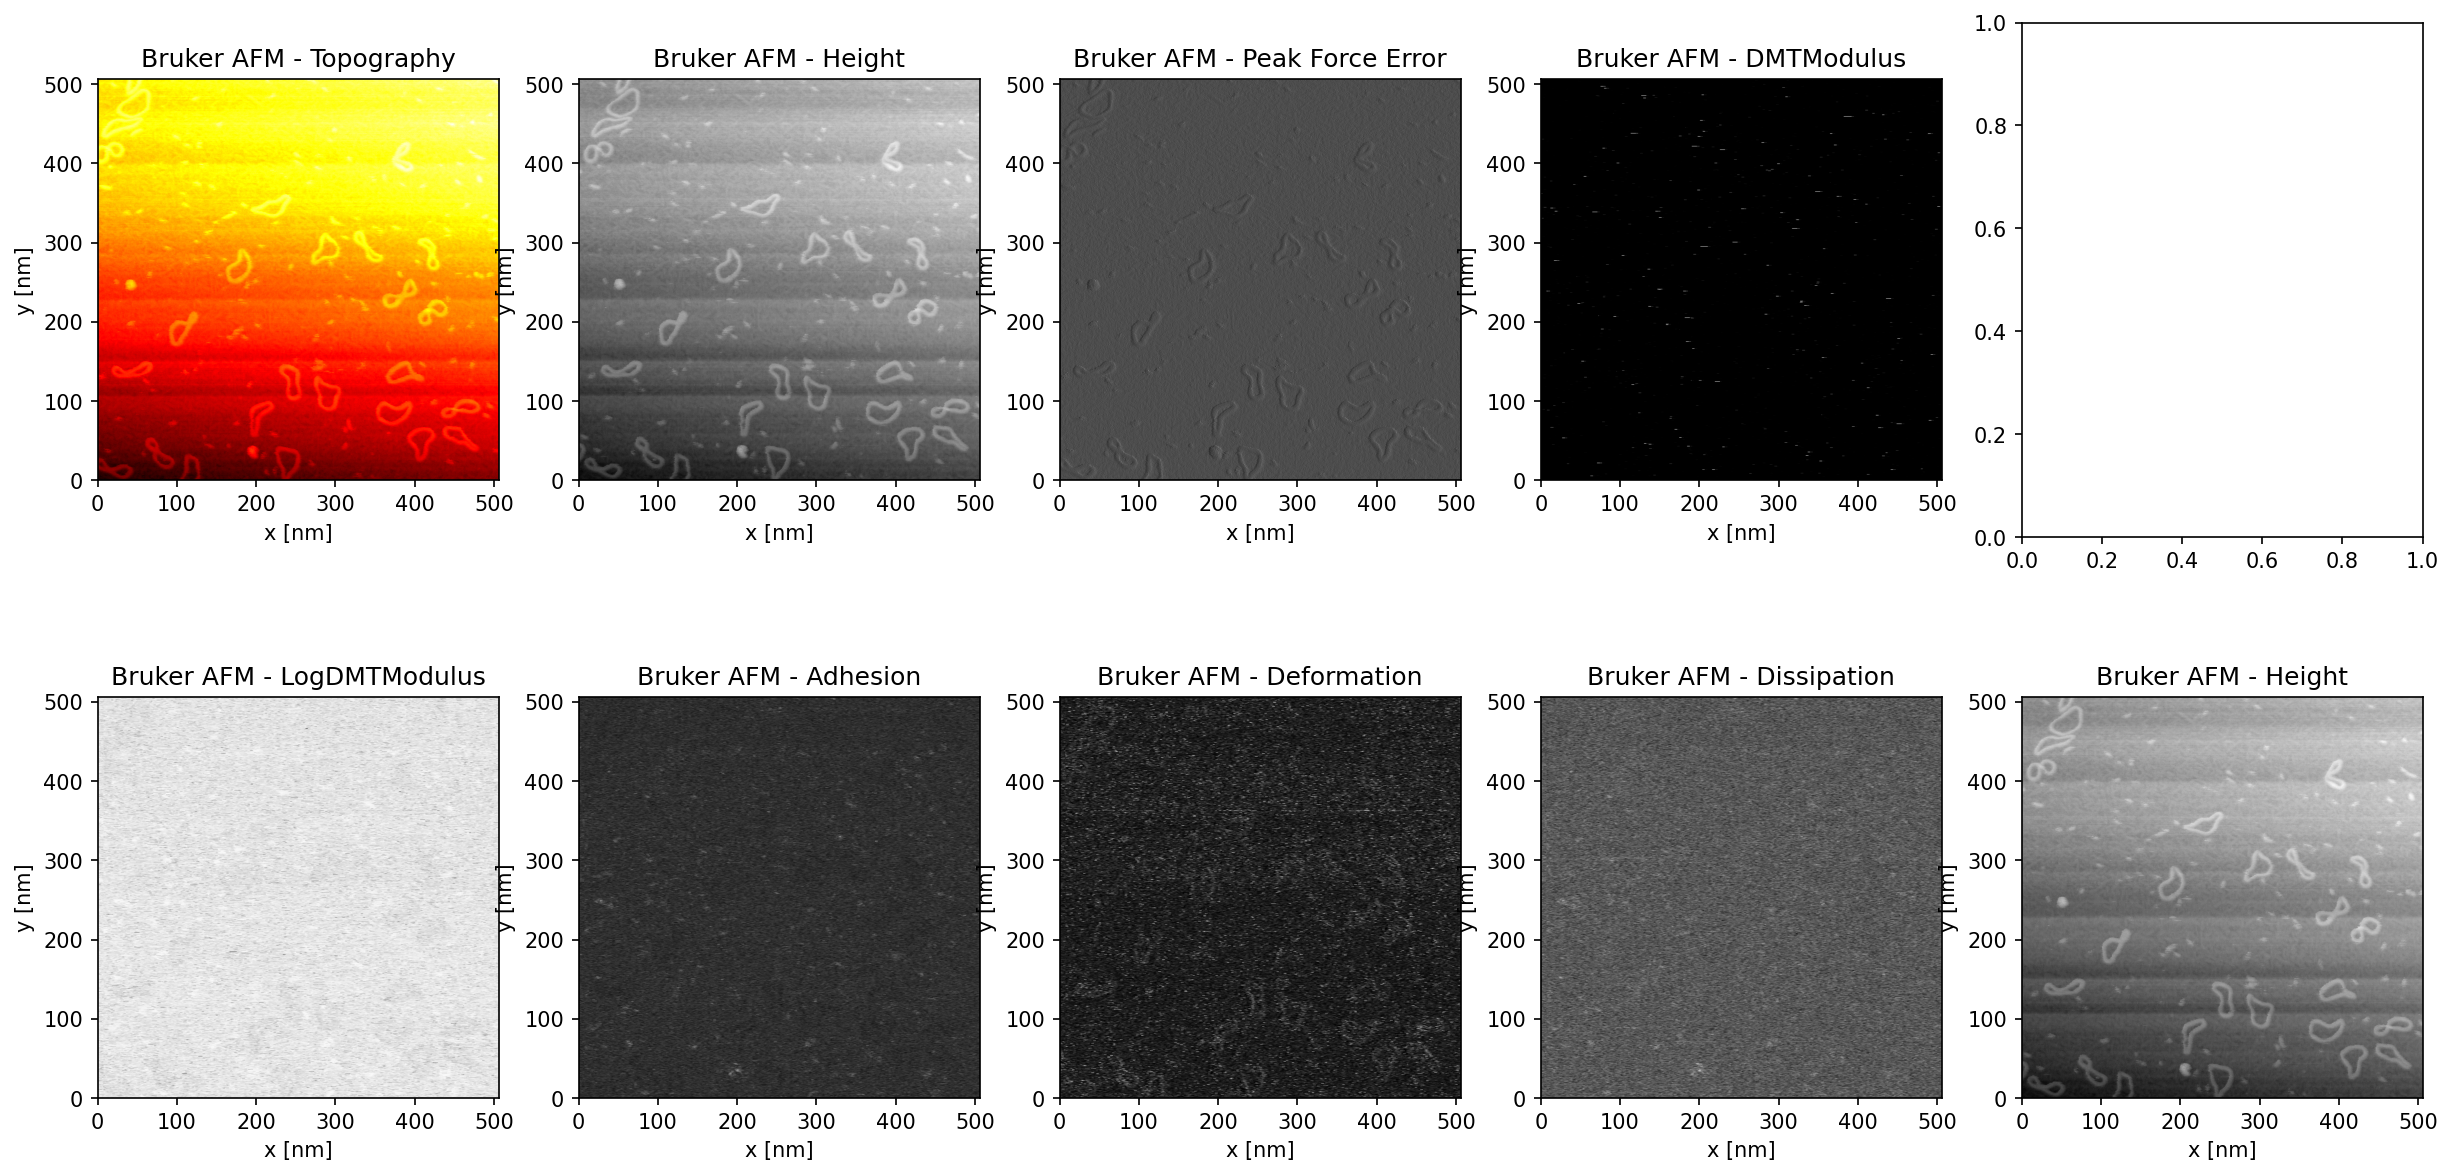

In [43]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import copy
import io
from skimage import morphology as skimorph
from skimage import filters as skifilter
from skimage import segmentation as skisegment
from skimage import measure as skimeasure
from skimage import exposure as skiexposure

import pySPM 
print(f'PySPM version: {pySPM.__version__}')

# Matplotlib config
%matplotlib inline
mpl.rcParams['figure.dpi'] = 150

# Get data
filename = 'minicircle.spm'
scan = pySPM.Bruker(filename)
scan.list_channels()

# Load data into variables
topography = scan.get_channel() 

zsensor = scan.get_channel("Height")
force_error = scan.get_channel("Peak Force Error")
dmtModulus = scan.get_channel("DMTModulus")
logDMTModulus = scan.get_channel("LogDMTModulus")
adhesion = scan.get_channel("Adhesion")
deformation = scan.get_channel("Deformation")
dissipation = scan.get_channel("Dissipation")
height = scan.get_channel("Height")

# Add figures
fig, ax = plt.subplots(2, 5, figsize=(20, 10))

topography.show(ax=ax[0,0])
zsensor.show(ax=ax[0,1])
force_error.show(ax=ax[0,2])
dmtModulus.show(ax=ax[0,3])
logDMTModulus.show(ax=ax[1,0])
adhesion.show(ax=ax[1,1])
deformation.show(ax=ax[1,2])
dissipation.show(ax=ax[1,3])
height.show(ax=ax[1,4])

# Set the data that we are going to try the corrections on
data = height


C:\Users\sylvi\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 21 fits in uint8
  return _convert(image, np.uint8, force_copy)


{'label': array([255]), 'bbox-0': array([163]), 'bbox-1': array([16]), 'bbox-2': array([1016]), 'bbox-3': array([992])}


Text(0.5, 1.0, 'Skeletonize 2d lee 94')

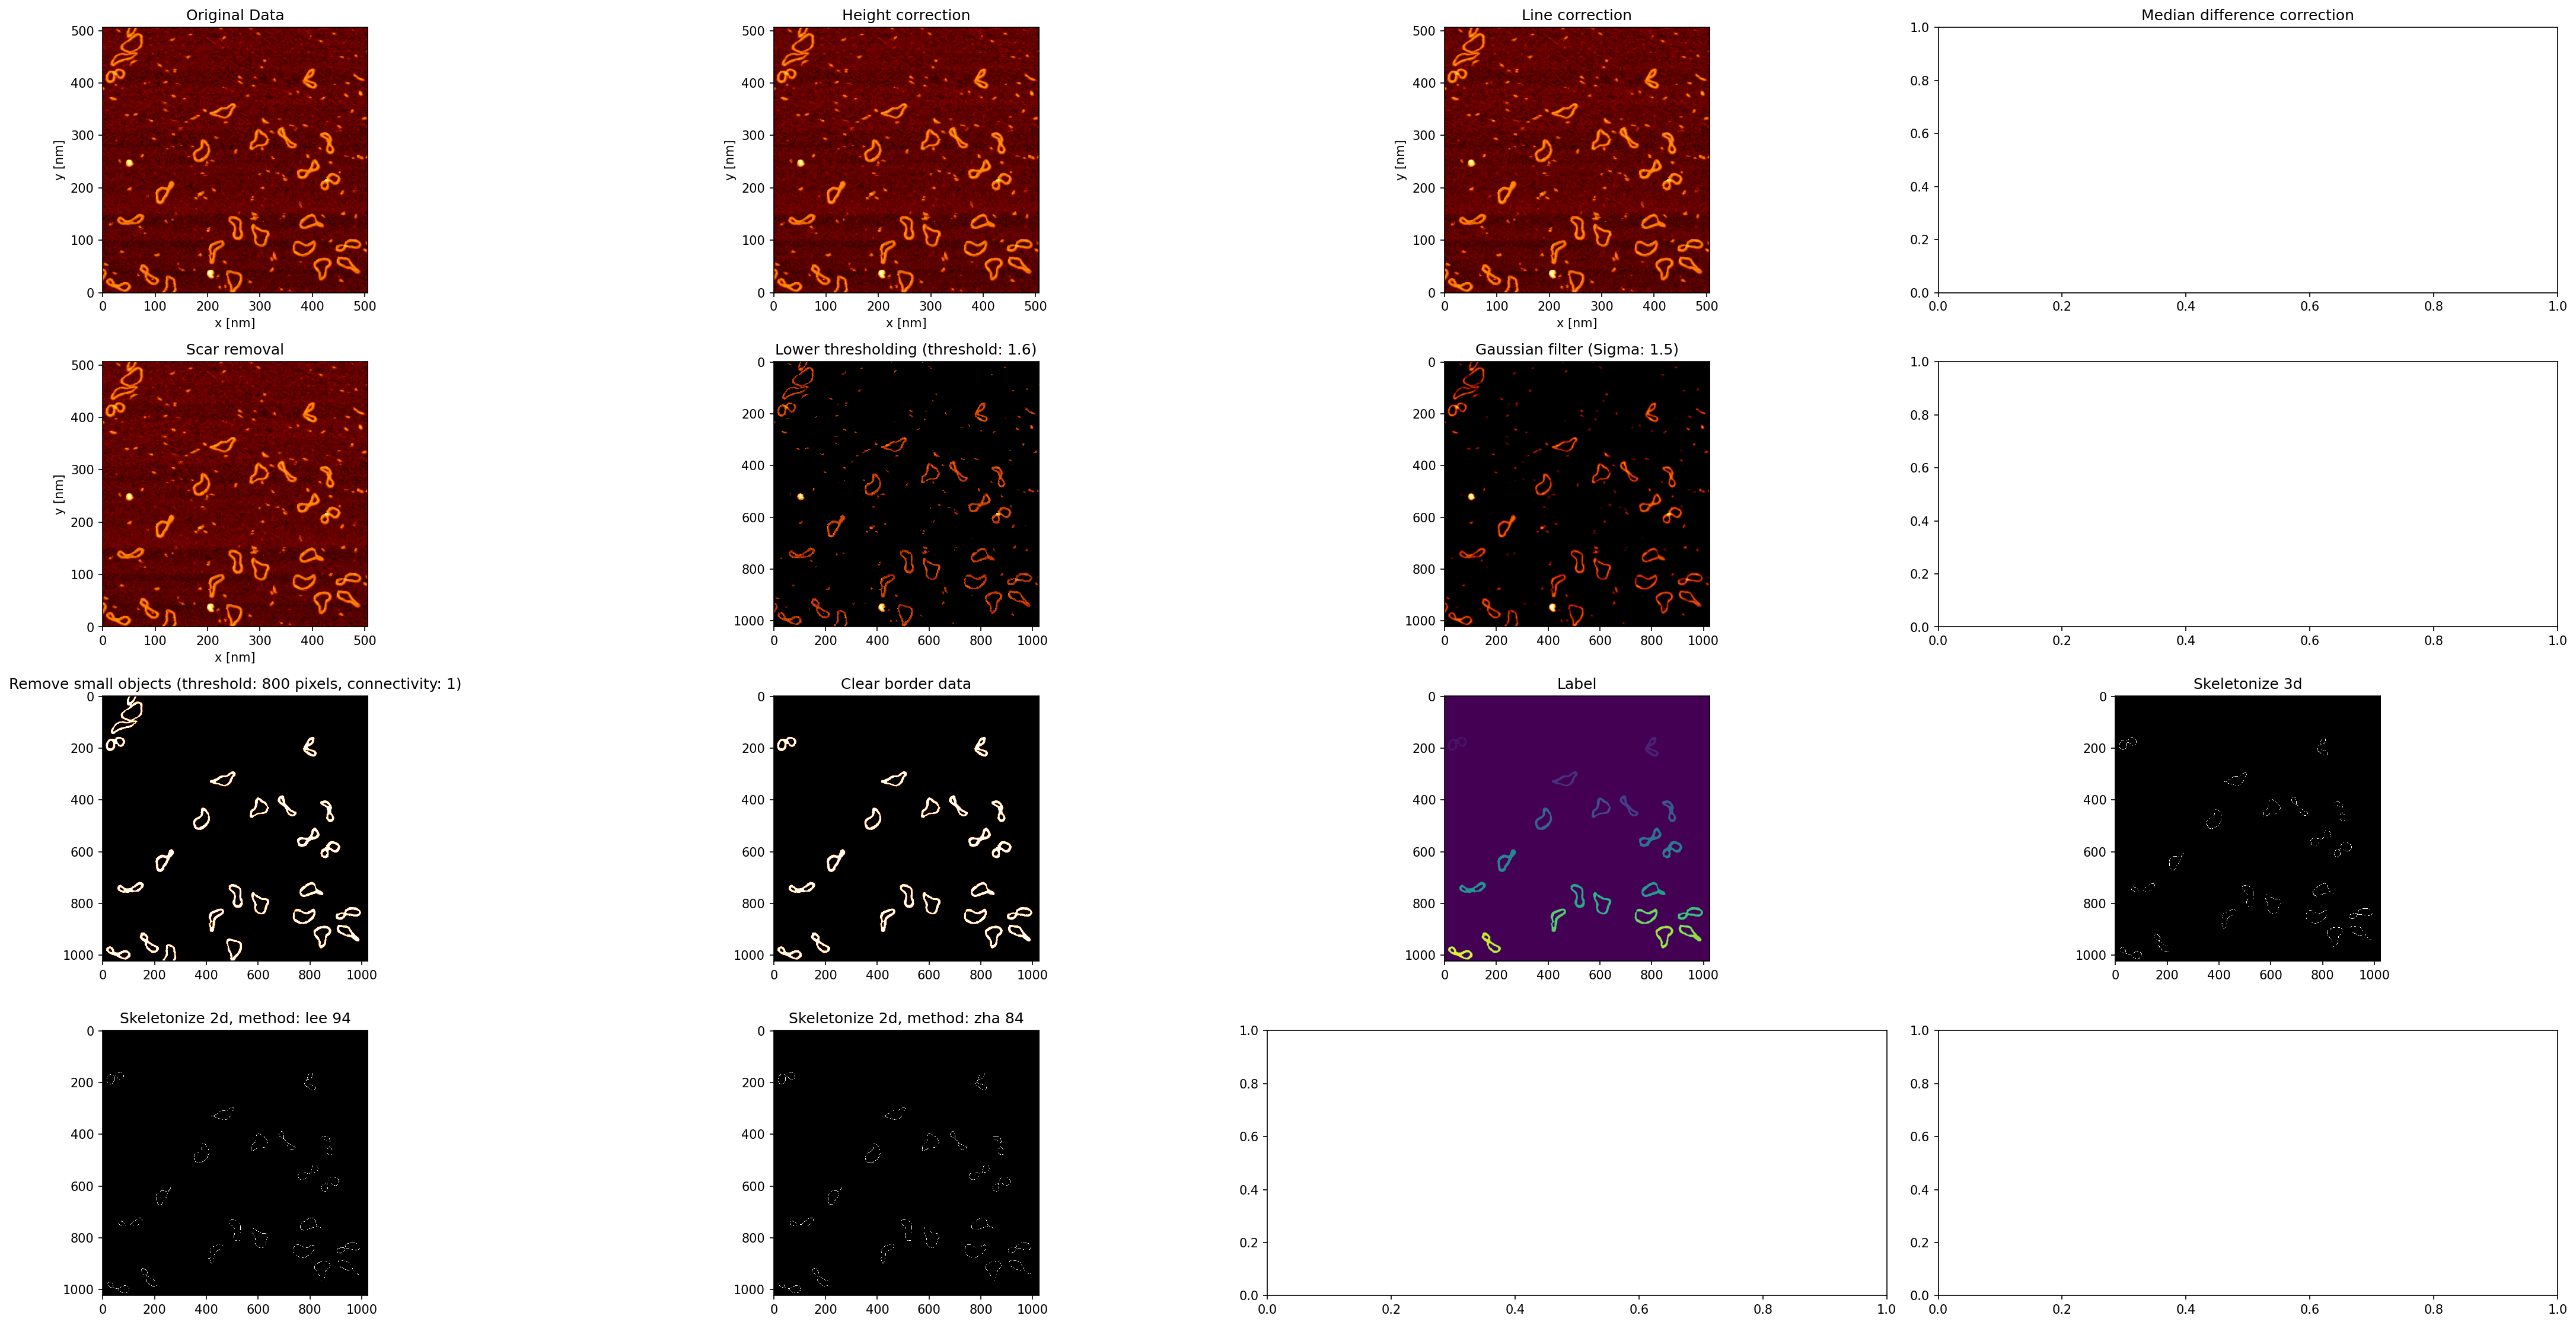

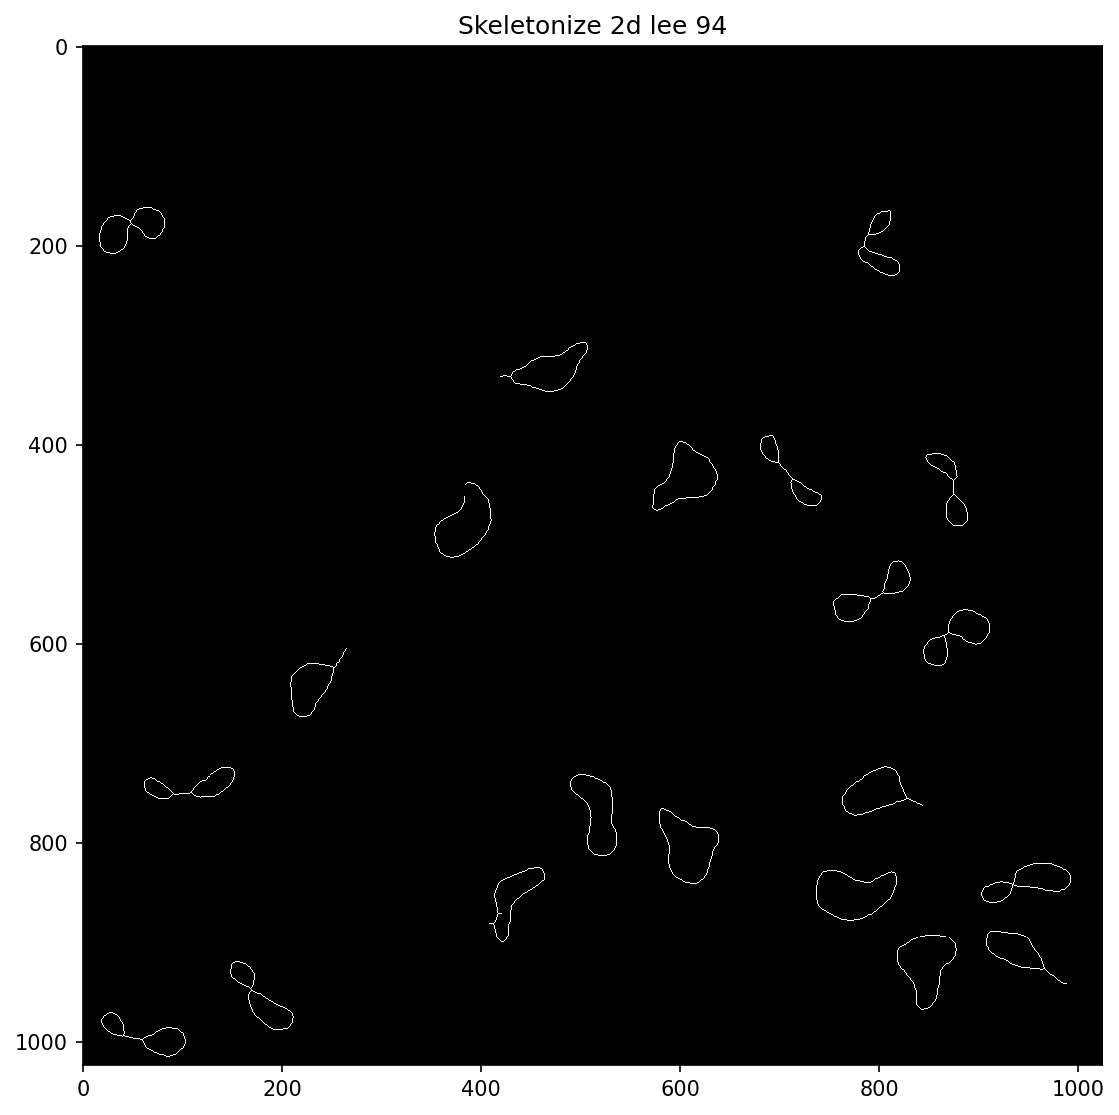

In [67]:
def showBig(datatoshow):
    largefigure, largeax = plt.subplots(1, 1, figsize = (18, 9))
    if isinstance(datatoshow, np.ndarray):
        largeax.imshow(data_pixelArray, interpolation="nearest")
    else:
        datatoshow.show(ax = largeax, interpolation="nearest")

# Colour map for the plots
colmap = 'afmhot'

# Figure for the plots
fig, ax = plt.subplots(4, 4, figsize = (30, 15))

# Original data
data.show(ax = ax[0, 0], cmap = colmap)
ax[0, 0].set_title('Original Data')

# Height correction
data = data.correct_plane()
data.show(ax = ax[0, 1], cmap = colmap)
ax[0, 1].set_title('Height correction')

# Line correction - remove lines across afm data
data = data.correct_lines()
data.show(ax = ax[0, 2], cmap = colmap)
ax[0, 2].set_title('Line correction')

# # Median difference correction - This does not work well
# data.correct_median_diff()
# data.show(ax = ax[0, 3], cmap = colmap)
ax[0, 3].set_title('Median difference correction')

# Remove scars
data = data.filter_scars_removal(0.7, inline = False)
data.show(ax = ax[1, 0], cmap = colmap)
ax[1, 0].set_title('Scar removal')

# Lower thresholding - Set all points below a threshold to zero
threshold_lowerbrightness = 1.6
data_pixelArray = np.array(data.pixels)
data_pixelArray[data_pixelArray < threshold_lowerbrightness] = 0
data_pixelArray = np.flipud(data_pixelArray)
ax[1, 1].imshow(data_pixelArray, cmap = colmap, interpolation="nearest")
ax[1, 1].set_title(f'Lower thresholding (threshold: {threshold_lowerbrightness})')

# Gaussian filter - to smooth data 
gaussian_sigma_value = 1.5
data_pixelArray = skifilter.gaussian(data_pixelArray, gaussian_sigma_value)
ax[1, 2].imshow(data_pixelArray, cmap = colmap)
ax[1, 2].set_title(f'Gaussian filter (Sigma: {gaussian_sigma_value})')

# # Upper thresholding - Set all points greater than a threshold to 1
# threshold_upperbrightness = 1.6
# data_pixelArray[data_pixelArray > threshold_upperbrightness] = 1
# ax[1, 3].imshow(data_pixelArray, cmap = colmap, interpolation="nearest")
# ax[1, 3].set_title(f'Upper thresholding (threshold: {threshold_upperbrightness})')

# Convert to integer values 
data_pixelArray = data_pixelArray.astype(int)

# Convert to boolean values - Essential for removing small objects
data_pixelArray = np.array(data_pixelArray, bool)

# Remove small objects
threshold_lowersize = 800
threshold_connectivity = 1
data_pixelArray = skimorph.remove_small_objects(data_pixelArray, threshold_lowersize, connectivity=threshold_connectivity)
ax[2, 0].imshow(data_pixelArray, cmap = colmap)
ax[2, 0].set_title(f'Remove small objects (threshold: {threshold_lowersize} pixels, connectivity: {threshold_connectivity})')

# Clear data near the border - Removing objects that intersect the axes borders
data_pixelArray = skisegment.clear_border(data_pixelArray)
ax[2, 1].imshow(data_pixelArray, cmap = colmap)
ax[2, 1].set_title(f'Clear border data')

# # Erosion
# data_pixelArray = skimorph.erosion(data_pixelArray, skimorph.disk(1))

# # Adjust log (does nothing?) 
# data_pixelArray = skiexposure.adjust_log(data_pixelArray, 1.05)

# # Adjust contrast
# data_pixelArray = skiexposure.adjust_sigmoid(data_pixelArray, cutoff=2.0, gain=4)

# # Adjust Gamma
# data_pixelArray = skiexposure.adjust_gamma(data_pixelArray, 0.8)

# Label - detects gaps in pixel groups
data_pixelArray = skimeasure.label(data_pixelArray)
ax[2, 2].imshow(data_pixelArray)
ax[2, 2].set_title(f'Label')

# Skeletonize

# 3d - Bad
skeleton3d = skimorph.skeletonize_3d(data_pixelArray)
ax[2, 3].imshow(skeleton3d, cmap = colmap, interpolation="nearest")
ax[2, 3].set_title('Skeletonize 3d')

# 2d lee - Good
skeleton2d_lee = skimorph.skeletonize(np.array(data_pixelArray, bool), method="lee")
ax[3, 0].imshow(skeleton2d_lee, cmap = colmap, interpolation="nearest")
ax[3, 0].set_title('Skeletonize 2d, method: lee 94')

# 2d zha - Bad
skeleton2d_zha = skimorph.skeletonize(np.array(data_pixelArray, bool))
ax[3, 1].imshow(skeleton2d_zha, cmap = colmap, interpolation="nearest")
ax[3, 1].set_title('Skeletonize 2d, method: zha 84')

# Measure properties of the regions
regions = skimeasure.regionprops_table(skeleton2d_lee)
print(regions)

fig.tight_layout()


# Show close-ups of the different skeleton methods
fig, ax = plt.subplots(1, 1, figsize = (18, 9))
ax.imshow(skeleton2d_lee, cmap = colmap, interpolation="nearest")
ax.set_title('Skeletonize 2d lee 94')

# fig, ax = plt.subplots(1, 1, figsize = (18, 9))
# ax.imshow(skeleton2d_zha, cmap = colmap, interpolation="nearest")
# ax.set_title('Skeletonize 2d zha 84')

# fig, ax = plt.subplots(1, 1, figsize = (18, 9))
# ax.imshow(skeleton3d, cmap = colmap, interpolation="nearest")
# ax.set_title('Skeletonize 3d')





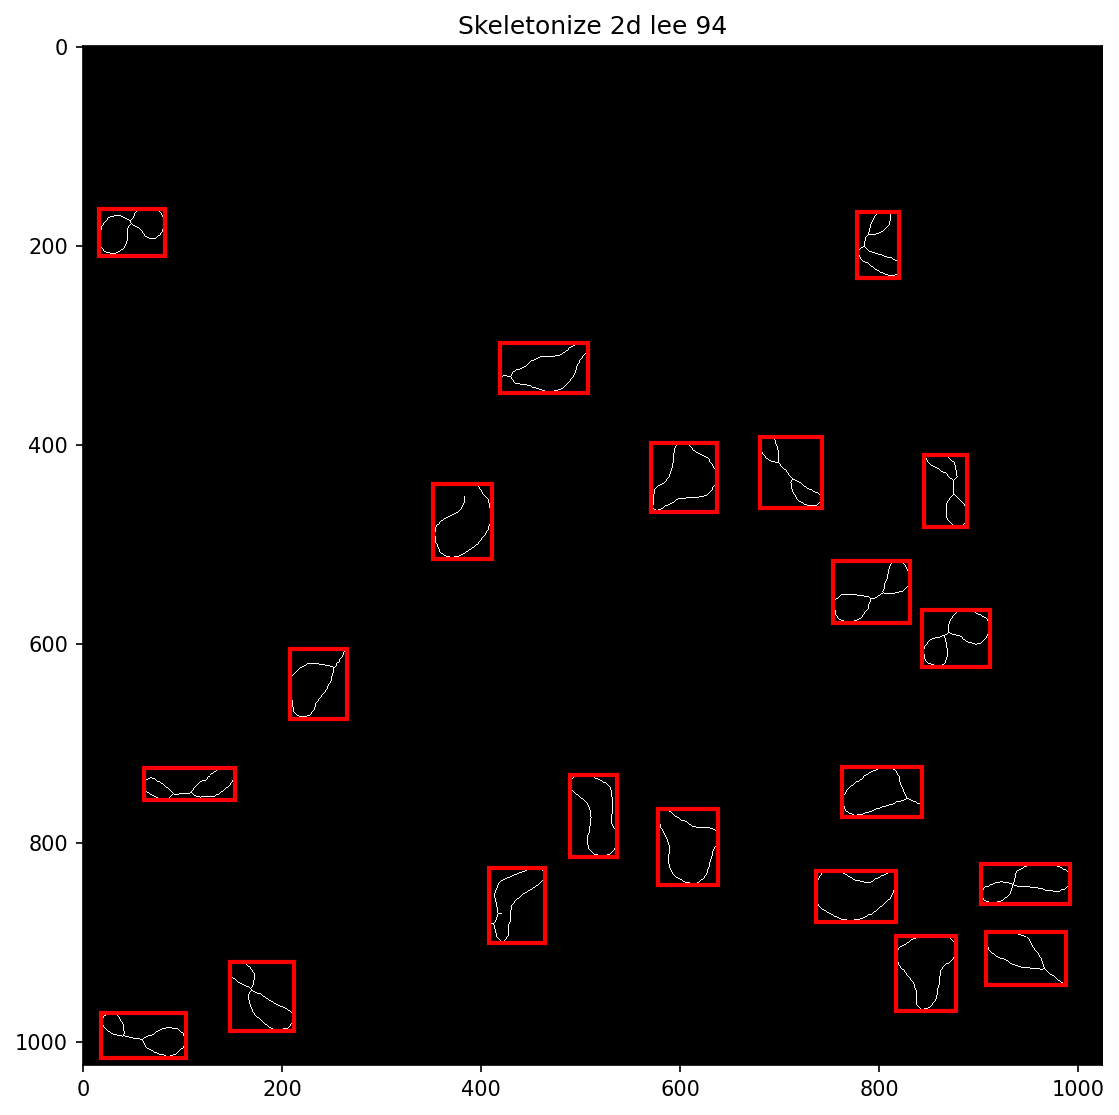

In [68]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(1, 1, figsize = (18, 9))
ax.imshow(skeleton2d_lee, cmap = colmap, interpolation="nearest")
ax.set_title('Skeletonize 2d lee 94')

for region in skimeasure.regionprops(skimeasure.label(skeleton2d_lee)):
    
    # draw rectangle around segmented areas
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

rows: 47 columns: 66
neighbours: 2
[(9, 22), (10, 24)]
9 22
x: 8 y: 21
neighbours: 1
x: 8 y: 20
neighbours: 1
x: 8 y: 19
neighbours: 1
x: 8 y: 18
neighbours: 1
x: 8 y: 17
neighbours: 1
x: 8 y: 16
neighbours: 1
x: 8 y: 15
neighbours: 1
x: 9 y: 14
neighbours: 1
x: 9 y: 13
neighbours: 1
x: 9 y: 12
neighbours: 1
x: 9 y: 11
neighbours: 1
x: 10 y: 10
neighbours: 1
x: 10 y: 9
neighbours: 1
x: 11 y: 8
neighbours: 1
x: 12 y: 8
neighbours: 1
x: 13 y: 7
neighbours: 1
x: 14 y: 6
neighbours: 1
x: 15 y: 5
neighbours: 1
x: 16 y: 4
neighbours: 1
x: 17 y: 4
neighbours: 1
x: 18 y: 3
neighbours: 1
x: 19 y: 2
neighbours: 1
x: 20 y: 2
neighbours: 1
x: 21 y: 2
neighbours: 1
x: 22 y: 2
neighbours: 1
x: 23 y: 1
neighbours: 1
x: 24 y: 1
neighbours: 1
x: 25 y: 1
neighbours: 1
x: 26 y: 0
neighbours: 1
x: 27 y: 0
neighbours: 1
x: 28 y: 0
neighbours: 1
x: 29 y: 0
neighbours: 1
x: 30 y: 0
neighbours: 1
x: 31 y: 0
neighbours: 1
x: 32 y: 0
neighbours: 1
x: 33 y: 0
neighbours: 1
x: 34 y: 0
neighbours: 1
x: 35 y: 1
nei

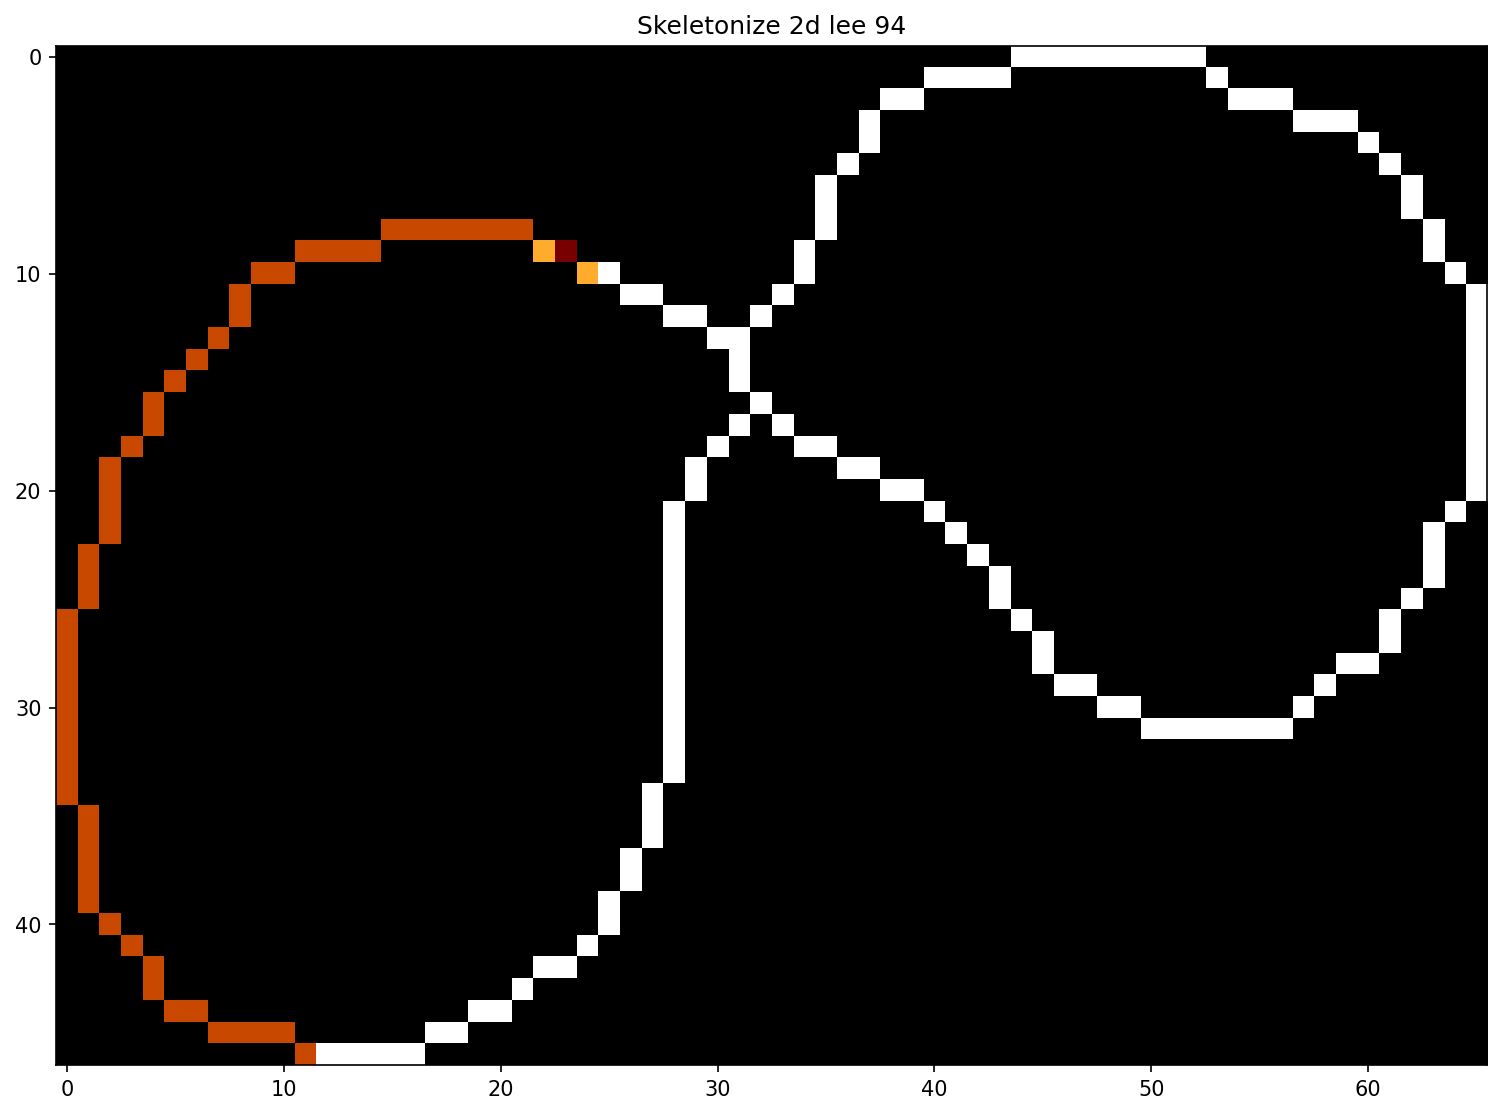

In [144]:
import time

state = np.random.RandomState(1)

# Take a skeleton
regiondata = None
region = skimeasure.regionprops(skimeasure.label(skeleton2d_lee))[0]
minr, minc, maxr, maxc = region.bbox
regiondata = np.array(skeleton2d_lee[minr:maxr, minc:maxc])

rows, cols = regiondata.shape[0], regiondata.shape[1]
print(f'rows: {rows} columns: {cols}')

fig, ax = plt.subplots(1, 1, figsize = (18, 9))
ax.imshow(regiondata, cmap = colmap, interpolation="nearest")
ax.set_title('Skeletonize 2d lee 94')

# Find a random 1 in the area
found = False
startpos = None
while not found:
    randx = state.randint(0, rows-1)
    randy = state.randint(0, cols-1)
    value = regiondata[randx, randy]
    if value == 255:
        found = True
        startpos = (randx, randy)
        regiondata[randx, randy] = 100


spline = []

# Find first neighbour
x = startpos[0]
y = startpos[1]
for test in range(1):
    # Search for neighbours
    neighbours = []
    for i in range(-1, 2):
        for j in range(-1, 2):
            #print(f'i: {i} j: {j}')
            value = regiondata[x + i, y + j]
            #print(value)
            if value != 0:
                if i != 0 or j != 0:
                    neighbours.append((x + i, y + j))
                    spline.append((x + i, y + j))
                    regiondata[x + i, y + j] = 150
                else:
                    regiondata[x + i, y + j] = 60
            else:
                regiondata[x + i, y + j] = 0
                
    print(f'neighbours: {len(neighbours)}')
    print(neighbours)



# Follow line
x = neighbours[0][0]
y = neighbours[0][1]
print(x, y)
for test in range(120):
    # Search for neighbours
    neighbours = []
    for i in range(-1, 2):
        for j in range(-1, 2):
            # Prevent searching outside of image borders
            if x != rows - 1 and y != cols - 1:
                #print(f'i: {i} j: {j}')
                value = regiondata[x + i, y + j]
                #print(value)
                if value == 255:
                    if i != 0 or j != 0:
                        neighbours.append((x + i, y + j))
                        spline.append((x + i, y + j))
                        regiondata[x + i, y + j] = 150
                    else:
                        regiondata[x + i, y + j] = 60
                else:
                    pass
                    # regiondata[x + i, y + j] = 0
                
    if len(neighbours) == 1:
        x = neighbours[0][0]
        y = neighbours[0][1]
        regiondata[x, y] = 100
    
    print(f'x: {x} y: {y}')

    print(f'neighbours: {len(neighbours)}')


print(f'start pos: {startpos}')
ax.imshow(regiondata, cmap = colmap, interpolation="nearest")
